In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Question 8

In [2]:
#8a -> generate simulated data set
X = np.random.normal(0,1,100)
epsilon = np.random.normal(0,0.25,100)

In [3]:
#8b -> generate labels
Y = 1 + 2*X + 3*X*X + 4*X*X*X + epsilon

In [4]:
#8c -> best subset selection
df = pd.DataFrame({"X" : X,
                   "X2" : np.power(X,2),
                   "X3" : np.power(X,3),
                   "X4" : np.power(X,4),
                   "X5" : np.power(X,5),
                   "X6" : np.power(X,6),
                   "X7" : np.power(X,7),
                   "X8" : np.power(X,8),
                   "X9" : np.power(X,9),
                   "X10" : np.power(X,10),
                   "Y" : Y})

df.head()

,X,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.424932,0.180567,0.076729,0.032604,0.013855,0.005887,0.002502,0.001063,0.000452,0.000192,2.841769
1,0.286562,0.082118,0.023532,0.006743,0.001932,0.000554,0.000159,0.000045,0.000013,0.000004,2.012873
2,-0.283894,0.080596,-0.022881,0.006496,-0.001844,0.000524,-0.000149,0.000042,-0.000012,0.000003,0.316894
3,-1.002801,1.005610,-1.008426,1.011251,-1.014083,1.016923,-1.019772,1.022628,-1.025492,1.028365,-1.959262
4,1.900114,3.610432,6.860231,13.035219,24.768397,47.062771,89.424614,169.916931,322.861482,613.473515,43.265820


In [5]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

lr=LinearRegression()

def findKBest(x,y,k):
    minMSE = math.inf
    best_features = np.array([])
    
    for feature_subset in combinations(x, k):
        feature_subset = np.array(feature_subset)
        
        if(k==1):
            lr.fit(x[feature_subset].to_numpy().reshape(-1,1),y)
        else:
            lr.fit(x[feature_subset],y)
        
        predictions = lr.predict(x[feature_subset])
        MSE = mean_squared_error(y,predictions)
        
        if MSE < minMSE:
            best_features = feature_subset
            minMSE = MSE
            
    return best_features

In [6]:
from sklearn.model_selection import cross_val_score

def bestSubsetSelection(x,y):
    minRMSE = math.inf
    best_model = np.array([])
    
    for i in range(1,len(x.columns)):
        features = findKBest(x,y,i)
        
        if(i==1):
            scores = cross_val_score(lr,x[features].to_numpy().reshape(-1,1),y,scoring="neg_mean_squared_error",cv=10)
        else:
            scores = cross_val_score(lr,x[features],y,scoring="neg_mean_squared_error",cv=10)
            
        RMSE = np.sqrt(-scores)
        if RMSE.mean() < minRMSE:
            minRMSE = RMSE.mean()
            best_model = features
            
        print(features,RMSE.mean())
                    
    return best_model,minRMSE

In [7]:
model,RMSE = bestSubsetSelection(df.drop("Y",axis=1),df["Y"])
print(model,RMSE)

['X3'] 4.97961406322013
['X2' 'X3'] 1.2039548930660946
['X' 'X2' 'X3'] 0.2309340187696476
['X' 'X2' 'X3' 'X4'] 0.23435693278656006
['X' 'X2' 'X3' 'X8' 'X10'] 0.23474649884705423
['X' 'X2' 'X3' 'X4' 'X6' 'X10'] 0.23096994342768706
['X' 'X2' 'X3' 'X4' 'X6' 'X8' 'X9'] 0.2700739428975078
['X' 'X2' 'X3' 'X4' 'X6' 'X8' 'X9' 'X10'] 0.24352652744428416
['X' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9'] 0.5785747842166451
['X' 'X2' 'X3'] 0.2309340187696476


In [8]:
#8d -> forward and backward stepwise selection
def findBestForwardSelectionModel(x,y,features,predictors):
    minMSE = math.inf
    best_predictor = np.array([])
    
    for predictor in predictors:
        predictor = np.array(predictor)
        
        if features.size == 0:
            features_subset = np.array(predictor)
            lr.fit(x[features_subset].to_numpy().reshape(-1,1),y)
            predictions = lr.predict(x[features_subset].to_numpy().reshape(-1,1))
        else:
            features_subset = np.append(features,predictor)
            lr.fit(x[features_subset],y) 
            predictions = lr.predict(x[features_subset])        
        
        MSE = mean_squared_error(y,predictions)
        
        if MSE < minMSE:
            best_predictor = predictor
            minMSE = MSE
        
    return best_predictor

In [9]:
def forwardSubsetSelection(x,y):
    minRMSE = math.inf
    best_model = np.array([])
    
    predictors = np.array(x.columns)
    features = np.array([])
    
    while len(predictors)>0:
        predictor = findBestForwardSelectionModel(x,y,features,predictors)
        predictor = np.array(predictor)
        predictors = predictors[predictors != predictor]
        
        if features.size == 0:
            features = np.array(predictor)
            scores = cross_val_score(lr,x[features].to_numpy().reshape(-1,1),y,scoring="neg_mean_squared_error",cv=10)
        else:
            features = np.append(features,predictor)
            scores = cross_val_score(lr,x[features],y,scoring="neg_mean_squared_error",cv=10)
        
        RMSE = np.sqrt(-scores)
        if RMSE.mean() < minRMSE:
            minRMSE = RMSE.mean()
            best_model = features
            
        print(features,RMSE.mean())
                    
    return best_model,minRMSE    

In [10]:
forwardSubsetSelection(df.drop("Y",axis=1),df["Y"])

X3 4.97961406322013
['X3' 'X2'] 1.203954893066098
['X3' 'X2' 'X'] 0.23093401876964906
['X3' 'X2' 'X' 'X4'] 0.23435693278655917
['X3' 'X2' 'X' 'X4' 'X9'] 0.23029014898798233
['X3' 'X2' 'X' 'X4' 'X9' 'X7'] 0.23414287213733487
['X3' 'X2' 'X' 'X4' 'X9' 'X7' 'X5'] 0.23391659578531093
['X3' 'X2' 'X' 'X4' 'X9' 'X7' 'X5' 'X6'] 0.27423873451785596
['X3' 'X2' 'X' 'X4' 'X9' 'X7' 'X5' 'X6' 'X8'] 0.5785747842169824
['X3' 'X2' 'X' 'X4' 'X9' 'X7' 'X5' 'X6' 'X8' 'X10'] 1.0518465619394568


(array(['X3', 'X2', 'X', 'X4', 'X9'], dtype='<U2'), 0.23029014898798233)

In [11]:
def findBestBackwardSelectionModel(x,y,features):
    minMSE = math.inf
    best_predictor = np.array([])
    feature_subset = features
    
    for predictor in features:
        predictor = np.array(predictor)
        feature_subset = features[features != predictor]
        
        if feature_subset.size == 1:
            lr.fit(x[feature_subset].to_numpy().reshape(-1,1),y)
            predictions = lr.predict(x[feature_subset].to_numpy().reshape(-1,1))
        else:
            lr.fit(x[feature_subset],y) 
            predictions = lr.predict(x[feature_subset])        
        
        MSE = mean_squared_error(y,predictions)
        
        if MSE < minMSE:
            best_predictor = predictor
            minMSE = MSE
        
    return best_predictor

In [12]:
def backwardSubsetSelection(x,y):
    minRMSE = math.inf
    best_model = np.array([])
    
    features = np.array(x.columns)
    
    while len(features)>1:
        predictor = findBestBackwardSelectionModel(x,y,features)
        predictor = np.array(predictor)
        features = features[features != predictor]
        
        if features.size == 1:
            scores = cross_val_score(lr,x[features].to_numpy().reshape(-1,1),y,scoring="neg_mean_squared_error",cv=10)
        else:
            scores = cross_val_score(lr,x[features],y,scoring="neg_mean_squared_error",cv=10)
        
        RMSE = np.sqrt(-scores)
        if RMSE.mean() < minRMSE:
            minRMSE = RMSE.mean()
            best_model = features
            
        print(features,RMSE.mean())
                    
    return best_model,minRMSE  

In [13]:
backwardSubsetSelection(df.drop("Y",axis=1),df["Y"])

['X' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9'] 0.5785747842166451
['X' 'X2' 'X3' 'X4' 'X5' 'X6' 'X8' 'X9'] 0.30971569175816144
['X' 'X2' 'X3' 'X4' 'X6' 'X8' 'X9'] 0.2700739428975078
['X' 'X2' 'X3' 'X4' 'X6' 'X8'] 0.23177292916147246
['X' 'X2' 'X3' 'X6' 'X8'] 0.23726878215627165
['X' 'X2' 'X3' 'X6'] 0.2375747030325559
['X' 'X2' 'X3'] 0.2309340187696476
['X2' 'X3'] 1.2039548930660946
['X3'] 4.97961406322013


(array(['X', 'X2', 'X3'], dtype=object), 0.2309340187696476)

In [14]:
#8e -> Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lr = Lasso(alpha=1)
param_grid=[{"alpha":np.linspace(0.0,100.0,200)}]

grid_search_lr = GridSearchCV(lr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_lr.fit(df.drop("Y",axis=1),df["Y"])

cvres = grid_search_lr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

1.0054142671730089 {'alpha': 0.0}
9.287646503727755 {'alpha': 0.5025125628140703}
18.48687581612714 {'alpha': 1.0050251256281406}
24.68654105148367 {'alpha': 1.507537688442211}
25.819589070797495 {'alpha': 2.0100502512562812}
24.119750914447344 {'alpha': 2.5125628140703515}
21.456303283573966 {'alpha': 3.015075376884422}
18.80057467726438 {'alpha': 3.517587939698492}
16.427108033239495 {'alpha': 4.0201005025125625}
14.186662422215424 {'alpha': 4.522613065326633}
13.434176251436211 {'alpha': 5.025125628140703}
12.514321063177377 {'alpha': 5.527638190954773}
11.565858864394105 {'alpha': 6.030150753768844}
10.654089749224505 {'alpha': 6.532663316582914}
9.830237870074933 {'alpha': 7.035175879396984}
9.089226350276487 {'alpha': 7.537688442211055}
8.453626832991462 {'alpha': 8.040201005025125}
7.903471727474609 {'alpha': 8.542713567839195}
7.4404243599268645 {'alpha': 9.045226130653266}
7.053640795287673 {'alpha': 9.547738693467336}
6.845416492292516 {'alpha': 10.050251256281406}
7.23971080

In [15]:
grid_search_lr.best_estimator_.coef_

array([ 2.15555390e+00,  2.96947846e+00,  3.79918617e+00, -2.61830948e-02,
        5.79756212e-02,  7.92709635e-03, -2.95523511e-03,  1.42002944e-04,
       -2.85201958e-04, -8.89715226e-05])

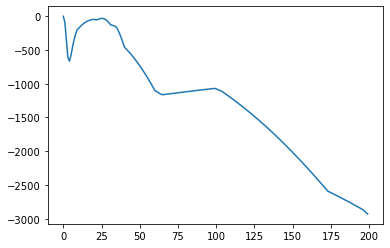

In [16]:
plt.plot(cvres["mean_test_score"])
plt.show()

In [17]:
#8f
df["Z"] = 1 + 8*np.power(X,7) + epsilon
df.head()

,X,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,Z
0,0.424932,0.180567,0.076729,0.032604,0.013855,0.005887,0.002502,0.001063,0.000452,0.000192,2.841769,1.163303
1,0.286562,0.082118,0.023532,0.006743,0.001932,0.000554,0.000159,0.000045,0.000013,0.000004,2.012873,1.100539
2,-0.283894,0.080596,-0.022881,0.006496,-0.001844,0.000524,-0.000149,0.000042,-0.000012,0.000003,0.316894,0.733228
3,-1.002801,1.005610,-1.008426,1.011251,-1.014083,1.016923,-1.019772,1.022628,-1.025492,1.028365,-1.959262,-7.094958
4,1.900114,3.610432,6.860231,13.035219,24.768397,47.062771,89.424614,169.916931,322.861482,613.473515,43.265820,716.590281


In [18]:
model,RMSE = bestSubsetSelection(df.drop(["Y","Z"],axis=1),df["Z"])
print(model,RMSE)

['X7'] 0.2297870918780498
['X7' 'X9'] 0.22989081431368677
['X4' 'X7' 'X10'] 0.30212825753164774
['X2' 'X4' 'X7' 'X10'] 0.3015916745158255
['X2' 'X3' 'X4' 'X7' 'X10'] 0.3156067162613611
['X' 'X2' 'X4' 'X5' 'X7' 'X8'] 0.22989071079827
['X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X10'] 20.846021831788825
['X' 'X2' 'X3' 'X4' 'X7' 'X8' 'X9' 'X10'] 5.728623718187553
['X' 'X2' 'X3' 'X4' 'X6' 'X7' 'X8' 'X9' 'X10'] 38.24529639541455
['X7'] 0.2297870918780498


In [19]:
grid_search_lr = GridSearchCV(lr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_lr.fit(df.drop(["Y","Z"],axis=1),df["Z"])

cvres = grid_search_lr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

35.94382036590909 {'alpha': 0.0}
62.125538441279716 {'alpha': 0.5025125628140703}
76.01943111814165 {'alpha': 1.0050251256281406}
89.10649020931757 {'alpha': 1.507537688442211}
101.41237022948526 {'alpha': 2.0100502512562812}
106.80736383316612 {'alpha': 2.5125628140703515}
110.45481989635438 {'alpha': 3.015075376884422}
107.68792783849278 {'alpha': 3.517587939698492}
105.83284776372471 {'alpha': 4.0201005025125625}
104.57669194421534 {'alpha': 4.522613065326633}
103.52136369735385 {'alpha': 5.025125628140703}
102.54822601185843 {'alpha': 5.527638190954773}
101.63916479487902 {'alpha': 6.030150753768844}
100.77749484262193 {'alpha': 6.532663316582914}
99.9197970439249 {'alpha': 7.035175879396984}
99.14338928849038 {'alpha': 7.537688442211055}
98.34189337781378 {'alpha': 8.040201005025125}
97.6139208901576 {'alpha': 8.542713567839195}
96.88427916185957 {'alpha': 9.045226130653266}
96.18543931654385 {'alpha': 9.547738693467336}
95.49461580488735 {'alpha': 10.050251256281406}
94.831358095

In [20]:
grid_search_lr.best_estimator_.coef_

array([ 1.30598019e+01, -1.87921047e+00, -3.32426498e+01,  1.43997345e-02,
        2.10723706e+01,  2.07994074e-01,  3.27263880e+00, -1.61684978e-03,
        3.40554713e-01, -4.60792694e-03])

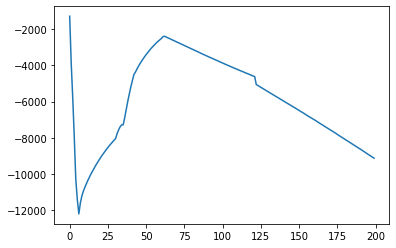

In [21]:
plt.plot(cvres["mean_test_score"])
plt.show()

### Question 9

In [22]:
college_path = "../../Data/College.csv"
college = pd.read_csv(college_path)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [23]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 

In [24]:
#9a -> split data into train and test set
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

X = college.drop("Apps",axis=1)
Y = college["Apps"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

numerical_pipeline = Pipeline([("standardization",StandardScaler())])
numerical_attributes = college.drop(["Apps","Private"],axis=1).columns

categorical_pipeline = Pipeline([("encoding",OneHotEncoder())])
categorical_attributes = ["Private"]

transformer = ColumnTransformer([("numerical_pipeline",numerical_pipeline,numerical_attributes),
                                 ("categorical_pipeline",categorical_pipeline,categorical_attributes)])

X_train_final = transformer.fit_transform(X_train)
X_test_final = transformer.fit_transform(X_test)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#9b -> linear regression
lr = LinearRegression()
lr.fit(X_train_final,Y_train)
predictions = lr.predict(X_train_final)
RMSE = np.sqrt(mean_squared_error(Y_train,predictions))
print(RMSE)

predictions = lr.predict(X_test_final)
RMSE = np.sqrt(mean_squared_error(Y_test,predictions))
print(RMSE)

995.0406856856827
1305.6974593914306


In [26]:
from sklearn.linear_model import Ridge

#9c -> ridge regression
rr = Ridge(alpha=1.0)
grid_search_rr = GridSearchCV(rr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_rr.fit(X_train_final,Y_train)

cvres = grid_search_rr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

1129.7461158815715 {'alpha': 0.0}
1134.0725739720149 {'alpha': 0.5025125628140703}
1136.7720189280717 {'alpha': 1.0050251256281406}
1139.5433682634973 {'alpha': 1.507537688442211}
1142.3690165799833 {'alpha': 2.0100502512562812}
1145.2345830714703 {'alpha': 2.5125628140703515}
1148.128273351302 {'alpha': 3.015075376884422}
1151.040380539279 {'alpha': 3.517587939698492}
1153.962892422711 {'alpha': 4.0201005025125625}
1156.8891800480576 {'alpha': 4.522613065326633}
1159.8137492883113 {'alpha': 5.025125628140703}
1162.7320414552141 {'alpha': 5.527638190954773}
1165.6402723607737 {'alpha': 6.030150753768844}
1168.5353017114803 {'alpha': 6.532663316582914}
1171.4145265753343 {'alpha': 7.035175879396984}
1174.2757940624188 {'alpha': 7.537688442211055}
1177.1173294238463 {'alpha': 8.040201005025125}
1179.9376765874683 {'alpha': 8.542713567839195}
1182.7356487748725 {'alpha': 9.045226130653266}
1185.510287328785 {'alpha': 9.547738693467336}
1188.26082725736 {'alpha': 10.050251256281406}
1190.9

In [27]:
rr = grid_search_rr.best_estimator_
predictions = rr.predict(X_train_final)
RMSE = np.sqrt(mean_squared_error(Y_train,predictions))
print(RMSE)

predictions = rr.predict(X_test_final)
RMSE = np.sqrt(mean_squared_error(Y_test,predictions))
print(RMSE)

994.9896025480588
1305.5452540055478


In [28]:
#9d -> lasso regression
lr = Lasso(alpha=1.0)
grid_search_lr = GridSearchCV(lr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_lr.fit(X_train_final,Y_train)

cvres = grid_search_lr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

1131.4666859093734 {'alpha': 0.0}
1131.6998948331834 {'alpha': 0.5025125628140703}
1131.9889738701174 {'alpha': 1.0050251256281406}
1132.3269397637985 {'alpha': 1.507537688442211}
1132.7282758486924 {'alpha': 2.0100502512562812}
1133.2038807872395 {'alpha': 2.5125628140703515}
1133.7368371137186 {'alpha': 3.015075376884422}
1134.3051608104054 {'alpha': 3.517587939698492}
1134.9340421246757 {'alpha': 4.0201005025125625}
1135.619526221037 {'alpha': 4.522613065326633}
1136.3440434243219 {'alpha': 5.025125628140703}
1137.1175619789362 {'alpha': 5.527638190954773}
1137.8889605611494 {'alpha': 6.030150753768844}
1138.744241081077 {'alpha': 6.532663316582914}
1139.639880498707 {'alpha': 7.035175879396984}
1140.524779913123 {'alpha': 7.537688442211055}
1141.4652005967034 {'alpha': 8.040201005025125}
1142.4089817312458 {'alpha': 8.542713567839195}
1143.2999448083376 {'alpha': 9.045226130653266}
1144.0544085601157 {'alpha': 9.547738693467336}
1144.8158445626616 {'alpha': 10.050251256281406}
1145

In [29]:
lr = grid_search_lr.best_estimator_
predictions = lr.predict(X_train_final)
RMSE = np.sqrt(mean_squared_error(Y_train,predictions))
print(RMSE)

predictions = lr.predict(X_test_final)
RMSE = np.sqrt(mean_squared_error(Y_test,predictions))
print(RMSE)

995.0406856856825
1305.697459391432


In [30]:
from sklearn.cross_decomposition import PLSRegression

#9f -> partial least squares
pls = PLSRegression()
pls.fit(X_train_final,Y_train)
predictions = pls.predict(X_train_final)
RMSE = np.sqrt(mean_squared_error(Y_train,predictions))
print(RMSE)

predictions = pls.predict(X_test_final)
RMSE = np.sqrt(mean_squared_error(Y_test,predictions))
print(RMSE)

1504.0035961730723
1252.7272110386443


### Question 10

In [31]:
#10a -> generate dataset
X = np.random.normal(0,1,size=(1000,12))
beta = np.random.normal(0,0.75,12)
beta[0] = 0
beta[2] = 0
beta[4] = 0
beta[5] = 0
beta[6] = 0
epsilon = np.random.normal(0,0.25,1000)

Y = np.matmul(X,beta) + epsilon
beta

array([ 0.        , -1.44723545,  0.        , -0.28812521,  0.        ,
        0.        ,  0.        , -1.39809494, -0.23312635,  1.00697133,
        0.61234203,  0.25967489])

In [32]:
df_X = pd.DataFrame(X)
df_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.658654,1.014577,-0.737553,1.192541,-1.547400,0.324321,-0.719356,-0.672503,-2.517327,-0.399300,-0.253870,-1.136084
1,1.240700,1.890091,-0.788329,0.291374,-0.285288,1.814086,0.106221,0.910851,-0.609461,-0.088068,1.370408,-0.912034
2,-0.493312,-1.966502,0.054649,-0.985942,1.286979,-0.343338,0.506294,1.547677,0.584334,-0.234209,-1.358142,-0.371223
3,-0.482508,-0.100281,-0.120084,-0.309277,-1.254288,1.628888,1.157198,0.554263,-1.296409,-0.697817,1.038374,-1.315987
4,2.336078,0.356795,-1.071784,-0.326560,-0.547745,1.185257,0.233602,-1.605608,-1.295554,0.018127,0.054436,1.157287


In [33]:
df_Y = pd.DataFrame(Y)
df_Y.head()

,0
0,-1.219533
1,-3.284534
2,-0.172380
3,-0.617638
4,2.273645


In [34]:
#10b -> split dataset into test and training data
X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(900, 12)
(100, 12)
(900, 1)
(100, 1)


In [35]:
#10c and 10d -> best subset selection
def bestSubsetSelection(x_train,y_train,x_test,y_test):    
    for i in range(1,len(x_train.columns)):
        features = findKBest(x_train,y_train,i)
        
        if(i==1):
            scores = cross_val_score(lr,x_train[features].to_numpy().reshape(-1,1),y_train,scoring="neg_mean_squared_error",cv=10)
        else:
            scores = cross_val_score(lr,x_train[features],y_train,scoring="neg_mean_squared_error",cv=10)
            
        RMSE = np.sqrt(-scores)
            
        if(i==1):
            predictions = lr.predict(x_test[features].to_numpy().reshape(-1,1))
        else:
            predictions = lr.predict(x_test[features])
            
        MSE = mean_squared_error(y_test,predictions)
        print(features,RMSE.mean(),np.sqrt(MSE))

In [36]:
bestSubsetSelection(X_train,Y_train,X_test,Y_test)

[1] 1.8370260232268698 2.321904108548974
[1 7] 1.260572209642647 2.704307883880141
[1 7 9] 0.778108808441189 3.057557147867381
[ 1  7  9 10] 0.5147062809545159 2.657348739487165
[ 1  3  7  9 10] 0.43351500790654873 2.3420396780972017
[ 1  3  7  9 10 11] 0.3404462143835292 2.193200078988639
[ 1  3  7  8  9 10 11] 0.2563497433260968 1.4152199830907943
[ 1  3  4  7  8  9 10 11] 0.2560273155404317 1.4359177080309347
[ 1  2  3  4  7  8  9 10 11] 0.25603930502864586 1.1318610291059592
[ 0  1  2  3  4  7  8  9 10 11] 0.25600644001295336 1.1313913129630837
[ 0  1  2  3  4  6  7  8  9 10 11] 0.2560307667304518 1.9974970234510647


### Question 11

In [37]:
boston_path = "../../Data/Boston.csv"
boston = pd.read_csv(boston_path)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [38]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [39]:
numerical_pipeline = Pipeline([("standardization",StandardScaler())])
numerical_attributes = boston.drop("crim",axis=1).columns

transformer = ColumnTransformer([("numerical_pipeline",numerical_pipeline,numerical_attributes)])
X = transformer.fit_transform(boston.drop("crim",axis=1))
X = pd.DataFrame(X)
X.columns = boston.drop("crim",axis=1).columns
Y = boston["crim"]

In [40]:
#best subset selection
def bestSubsetSelection(x,y):
    minRMSE = math.inf
    best_model = np.array([])
    
    for i in range(1,len(x.columns)):
        features = findKBest(x,y,i)
        
        if(i==1):
            scores = cross_val_score(lr,x[features].to_numpy().reshape(-1,1),y,scoring="neg_mean_squared_error",cv=10)
        else:
            scores = cross_val_score(lr,x[features],y,scoring="neg_mean_squared_error",cv=10)
            
        RMSE = np.sqrt(-scores)
        if RMSE.mean() < minRMSE:
            minRMSE = RMSE.mean()
            best_model = features
            
        print(features,RMSE.mean())
                    
    return best_model,minRMSE

In [41]:
model,RMSE = forwardSubsetSelection(X,Y)
print(model,RMSE)

rad 4.390217942664966
['rad' 'lstat'] 4.6201440744789375
['rad' 'lstat' 'black'] 4.725860926919028
['rad' 'lstat' 'black' 'medv'] 4.84649205544103
['rad' 'lstat' 'black' 'medv' 'zn'] 4.8392309271598295
['rad' 'lstat' 'black' 'medv' 'zn' 'dis'] 4.930888410436262
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox'] 5.037136192818444
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio'] 5.093315981046102
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio' 'indus'] 5.106831675116441
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio' 'indus' 'rm'] 5.166752195816107
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio' 'indus' 'rm'
 'tax'] 5.213821176666796
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio' 'indus' 'rm'
 'tax' 'chas'] 5.246964029981143
['rad' 'lstat' 'black' 'medv' 'zn' 'dis' 'nox' 'ptratio' 'indus' 'rm'
 'tax' 'chas' 'age'] 5.295446235230466
rad 4.390217942664966


In [42]:
#lasso regression
lr = Lasso(alpha=1)
param_grid=[{"alpha":np.linspace(0.0,100.0,200)}]

grid_search_lr = GridSearchCV(lr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_lr.fit(X,Y)

cvres = grid_search_lr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

7.049644892674062 {'alpha': 0.0}
6.888821564123121 {'alpha': 0.5025125628140703}
7.026229272473275 {'alpha': 1.0050251256281406}
7.255941777740444 {'alpha': 1.507537688442211}
7.567142569282881 {'alpha': 2.0100502512562812}
7.93575542301775 {'alpha': 2.5125628140703515}
8.364386002832212 {'alpha': 3.015075376884422}
8.624116918305536 {'alpha': 3.517587939698492}
8.769991728239571 {'alpha': 4.0201005025125625}
8.882490926076153 {'alpha': 4.522613065326633}
8.948781477293364 {'alpha': 5.025125628140703}
9.021932540753557 {'alpha': 5.527638190954773}
9.10177870399531 {'alpha': 6.030150753768844}
9.118712882194515 {'alpha': 6.532663316582914}
9.118712882194515 {'alpha': 7.035175879396984}
9.118712882194515 {'alpha': 7.537688442211055}
9.118712882194515 {'alpha': 8.040201005025125}
9.118712882194515 {'alpha': 8.542713567839195}
9.118712882194515 {'alpha': 9.045226130653266}
9.118712882194515 {'alpha': 9.547738693467336}
9.118712882194515 {'alpha': 10.050251256281406}
9.118712882194515 {'alp

In [43]:
grid_search_lr.best_estimator_

Lasso(alpha=0.5025125628140703)

In [44]:
lr = grid_search_lr.best_estimator_
predictions = lr.predict(X)
RMSE = np.sqrt(mean_squared_error(Y,predictions))
print(RMSE)

6.510634506345201


In [45]:
#ridge regression
rr = Ridge(alpha=1.0)
grid_search_rr = GridSearchCV(rr,param_grid,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search_rr.fit(X,Y)

cvres = grid_search_rr.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

7.049644892674053 {'alpha': 0.0}
7.041977764301711 {'alpha': 0.5025125628140703}
7.03470527158582 {'alpha': 1.0050251256281406}
7.027804623559665 {'alpha': 1.507537688442211}
7.021254630933022 {'alpha': 2.0100502512562812}
7.015035569791481 {'alpha': 2.5125628140703515}
7.009129059248183 {'alpha': 3.015075376884422}
7.003517951341841 {'alpha': 3.517587939698492}
6.99818623172169 {'alpha': 4.0201005025125625}
6.993118929865238 {'alpha': 4.522613065326633}
6.988302037746197 {'alpha': 5.025125628140703}
6.983722436014286 {'alpha': 5.527638190954773}
6.979367826870507 {'alpha': 6.030150753768844}
6.975226672925162 {'alpha': 6.532663316582914}
6.971288141414175 {'alpha': 7.035175879396984}
6.96754205322512 {'alpha': 7.537688442211055}
6.963978836249434 {'alpha': 8.040201005025125}
6.960589482633603 {'alpha': 8.542713567839195}
6.957365509550806 {'alpha': 9.045226130653266}
6.9542989231569 {'alpha': 9.547738693467336}
6.951382185431547 {'alpha': 10.050251256281406}
6.948608183637589 {'alpha'

In [46]:
grid_search_rr.best_estimator_

Ridge(alpha=34.17085427135678)

In [47]:
rr = grid_search_rr.best_estimator_
predictions = rr.predict(X)
RMSE = np.sqrt(mean_squared_error(Y,predictions))
print(RMSE)

6.385096157818287
